# $\mathcal{l}_2$ penalty method algorithm

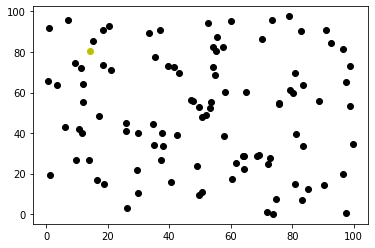

In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
import sklearn.datasets
from math import pi, sin, cos
def ren(x): return range(len(x))
#no. of sensors
FIELDSIZE = 100
#sensor location range
SCALE = 100
S = np.array([random.random()*SCALE, random.random()*SCALE])
X = np.array([ [ random.random()*SCALE, random.random()*SCALE ] for i in range(FIELDSIZE) ])
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.show()
def s_x_list(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        arr1.append(t1)
    return np.array(arr1)
def norms_sqrd(s,x):
    arr1 = []
    for i in range(FIELDSIZE):
        t1 = s - x[i]
        t2 = np.array(t1)
        t3 = np.linalg.norm(t2)**2
        arr1.append(t3)
    return np.array(arr1)
def gradient_function(s,x,k,b):
    N = norms_sqrd(s,x)
    s_minus_x = s_x_list(s,x)
    g_max = []
    if  max(norms_sqrd(s,x)) < b: #update beta if its closer
        b = max(norms_sqrd(s,x))
    for i in range(FIELDSIZE):
        g = N[i] - b
        g_plus = max(0,g)
        g_max.append(s_minus_x[i]*g_plus)
    grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
    return grad

# Adaptive GD, Steepest Descent

In [2]:
# Adaptive GD, Steepest Descent
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)
def Descent(s,x, EPSILON):
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_adaptive = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_adaptive = [grad_norm]
    time_list_adaptive =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    theta = float(random.getrandbits(128)) # this should essentially be infinity
    s1 = GD(s0,x,k,beta,lam)
    s_list_adaptive.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_adaptive.append(grad_norm)
    time_list_adaptive.append(time.time() - t_start)
    k=2
    while grad_norm > EPSILON:
        old_lam = lam
        min1 = np.sqrt(1 + theta)*old_lam
        min2 = np.linalg.norm(s1-s0)/(2*np.linalg.norm(gradient_function(s1, x, k, beta) - gradient_function(s0, x, k, beta) ))
        lam = np.min([min1, min2])
        theta = lam/old_lam
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
        s_list_adaptive.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_adaptive.append(grad_norm)
        time_list_adaptive.append(time.time() - t_start)
        k+=1
    return np.array([s_list_adaptive, norm_list_adaptive, time_list_adaptive])

In [3]:
TEST = Descent(S,X,1e-6)

<ipython-input-2-7cdcab5c5f48>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_adaptive, norm_list_adaptive, time_list_adaptive])


In [4]:
s_x_axis_adaptive = [TEST[0][i][0] for i in ren(TEST[0])]
s_y_axis_adaptive = [TEST[0][i][1] for i in ren(TEST[0])]
norm_adaptive = TEST[1]
time_adaptive = TEST[2]

# Barzalai Borwein, BFGS

In [5]:
# Barzalai Borwein, BFGS
def GD(s,direction, step): return s + step*direction
def Descent(s,x, EPSILON):
    H0 = np.array([[1,0],[0,1]])
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] )
    d = -H0@gradient_function(s0,x,k,beta).T
    s1 = GD(s0,d,lam)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    
    while grad_norm > EPSILON:
        sigma = s1 - s0
        g = gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta)
        r = (H0@g.T)/np.dot(sigma,g)
        H1 = H0 + ((1 + np.dot(r,g))/np.dot(sigma,g))*sigma.T@sigma - ( sigma.T@r - r.T@sigma )
        d = - H1@gradient_function(s1,x,k,beta).T
        nom = np.dot(s1 - s0, gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))
        denom = np.linalg.norm(gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))**2
        lam = nom/denom
        s0 = s1
        s1 = GD(s0, d , lam )
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
        H0 = H1
        k+=1
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [6]:
TEST2 = Descent(S,X,1e-6)

<ipython-input-5-d09f2c7a6e0b>:25: RuntimeWarning: invalid value encountered in true_divide
  r = (H0@g.T)/np.dot(sigma,g)
<ipython-input-5-d09f2c7a6e0b>:30: RuntimeWarning: invalid value encountered in double_scalars
  lam = nom/denom
<ipython-input-5-d09f2c7a6e0b>:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_list_baz])


In [7]:
TEST2

array([[array([14.1639626, 80.2590255]),
        array([14.17657031, 80.24882482]),
        array([58.18517618, 57.45900206]),
        array([20.00971072, 19.2835366 ]),
        array([522.91461344, 522.18843932]),
        array([-23881.12238943, -23881.80091585]),
        array([3528787.03066454, 3528786.30268908]),
        array([-1.54804487e+09, -1.54804488e+09]),
        array([2.03133102e+12, 2.03133102e+12]),
        array([-7.9884317e+15, -7.9884317e+15]),
        array([9.42142907e+19, 9.42142907e+19]),
        array([-3.33306852e+24, -3.33306852e+24]),
        array([3.53733828e+29, 3.53733828e+29]),
        array([-1.12622391e+35, -1.12622391e+35]),
        array([1.07570288e+41, 1.07570288e+41]),
        array([-3.08234018e+47, -3.08234018e+47]),
        array([2.6496582e+54, 2.6496582e+54]),
        array([2.6496582e+54, 2.6496582e+54]), array([nan, nan])],
       [9502.42718093213, 9499.183675277414, 2003.8491895965196,
        8793.80301067905, 928602111319.6193, 1.938469

In [8]:
s_x_axis_bad_baz = [TEST2[0][i][0] for i in range(len(TEST2[0])-1)]
s_y_axis_bad_baz = [TEST[0][i][1] for i in range(len(TEST2[0])-1)]
norm_bad_baz = TEST2[1][0:-1]
time_bad_baz = TEST2[2][0:-1]

# Barzilai-Borwein GD, Steepest Descent

In [9]:
# Barzilai-Borwein GD, Steepest Descent
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)
def Descent(s,x, EPSILON):
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = 1 / np.max( np.linalg.svd( x @ x.T ) [1] ) # approximating Lipschitz constant with SVD (MATLAB ok)
    s1 = GD(s0,x,k,beta,lam)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    while grad_norm > EPSILON:
        nom = np.dot(s1 - s0, gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))
        denom = np.linalg.norm(gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta))**2
        lam = nom/denom
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
        k+=1
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [10]:
TEST3 = Descent(S,X,1e-6)

<ipython-input-9-aee50c3f59ce>:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_list_baz])


In [11]:
TEST3

array([[array([14.1639626, 80.2590255]),
        array([14.17657031, 80.24882482]),
        array([51.10049943, 50.37432531])],
       [9502.42718093213, 9499.183675277414, 1.2391809430644094e-09],
       [0.007937192916870117, 0.021293163299560547, 0.038202762603759766]],
      dtype=object)

In [12]:
s_x_axis_baz = [round(TEST3[0][i][0],4) for i in ren(TEST3[0])]
s_y_axis_baz = [round(TEST3[0][i][1],4) for i in ren(TEST3[0])]
norm_baz = TEST3[1]
time_baz = TEST3[2]

# Line Search, Steepest Descent

In [13]:
def BackTrack(s, x, k, beta):
    rho = random.random()
    lam = random.randrange(1e6)
    grad_s = gradient_function(s,x,k,beta)
    while lam > ( np.linalg.norm(lam*grad_s ) / \
                 np.linalg.norm( gradient_function(s - lam*grad_s, x, k, beta ) - grad_s )  ):
        lam = rho * lam
    return lam
def GD(s,x,k,b, step): return s - step*gradient_function(s,x,k,b)
def Descent(s,x, EPSILON):
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = BackTrack(s0, x, k, beta)
    s1 = GD(s0,x,k,beta,lam)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    while grad_norm > EPSILON:
        lam = BackTrack(s1, x, k, beta)
        s0 = s1
        s1 = GD(s0, x, k, beta, lam )
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
        k+=1
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [14]:
TEST4 = Descent(S,X,1e-6)

<ipython-input-13-f42036dc2d54>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_list_baz])


In [15]:
s_x_axis_line = [round(TEST4[0][i][0],4) for i in ren(TEST4[0])]
s_y_axis_line = [round(TEST4[0][i][1],4) for i in ren(TEST4[0])]
norm_line = TEST4[1]
time_line = TEST4[2]

In [53]:
len(TEST4[0])

14

In [54]:
len(TEST[0])

36

# Tests

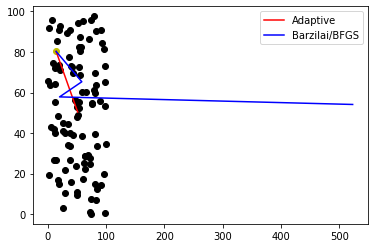

In [17]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, 'r', label = 'Adaptive')
plt.plot(s_x_axis_bad_baz[0:5], s_y_axis_bad_baz[0:5], 'b', label = 'Barzilai/BFGS')
plt.legend(loc='best')
plt.savefig('Adap_vs_Baz_steps3.png')
plt.show()

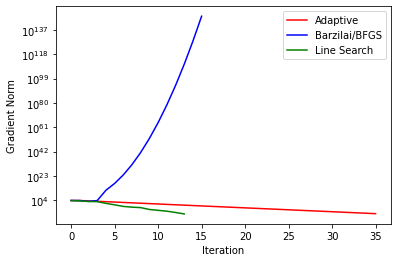

In [18]:
plt.plot(ren(norm_adaptive), norm_adaptive, 'r', label = 'Adaptive')
plt.plot(ren(norm_bad_baz), norm_bad_baz, 'b', label = 'Barzilai/BFGS')
plt.plot(ren(norm_line), norm_line, 'g', label = 'Line Search')
plt.legend(loc='best')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Baz_norms3.png')
plt.show()

## Nice Bas

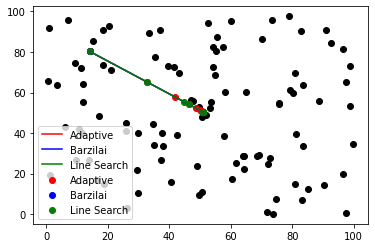

In [19]:
# Full plot
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.scatter(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.scatter(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.scatter(s_x_axis_line, s_y_axis_line, c = 'g', label = 'Line Search')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.plot(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.plot(s_x_axis_line, s_y_axis_line, c = 'g', label = 'Line Search')
plt.legend(loc='best')
plt.savefig('Adap_vs_Pure_Baz_steps3.png')
plt.show()

In [20]:
TEST[0][0]

array([14.1639626, 80.2590255])

In [21]:
TEST[0][-1]

array([51.10049942, 50.37432531])

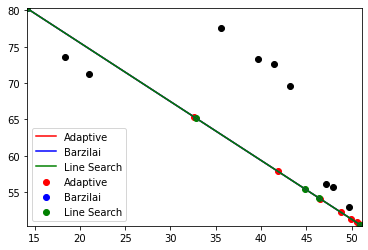

In [22]:
# small plot
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.xlim(min(TEST[0][0][0], TEST[0][-1][0]), max(TEST[0][0][0], TEST[0][-1][0]))
plt.ylim(min(TEST[0][0][1], TEST[0][-1][1]), max(TEST[0][0][1], TEST[0][-1][1]))
plt.scatter(x0,x1, c = 'k')
plt.scatter(S[0], S[1], c = 'y')
plt.scatter(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.scatter(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.scatter(s_x_axis_line, s_y_axis_line, c = 'g', label = 'Line Search')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, c ='r', label = 'Adaptive')
plt.plot(s_x_axis_baz, s_y_axis_baz, c ='b', label = 'Barzilai')
plt.plot(s_x_axis_line, s_y_axis_line, c = 'g', label = 'Line Search')
plt.legend(loc='best')
plt.savefig('Adap_vs_Pure_Baz_steps3_small.png')
plt.show()

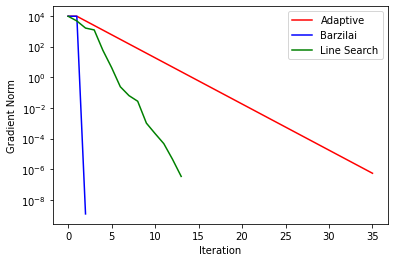

In [23]:
plt.plot(ren(norm_adaptive), norm_adaptive, 'r', label = 'Adaptive')
plt.plot(ren(norm_baz), norm_baz, 'b', label = 'Barzilai')
plt.plot(ren(norm_line), norm_line, 'g', label = 'Line Search')
plt.legend(loc='best')
plt.xlabel('Iteration')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Pure_Baz_norms3.png')
plt.show()

In [24]:
round(time_adaptive[-1],4)

0.4657

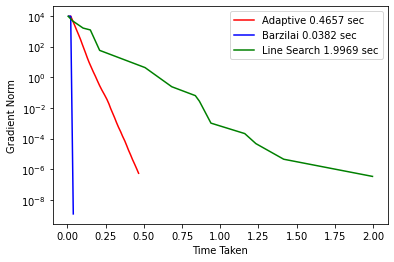

In [25]:
plt.plot(time_adaptive, norm_adaptive, 'r', label = 'Adaptive {} sec'.format(round(time_adaptive[-1],4)))
plt.plot(time_baz, norm_baz, 'b', label = 'Barzilai {} sec'.format(round(time_baz[-1],4)))
plt.plot(time_line, norm_line, 'g', label = 'Line Search {} sec'.format(round(time_line[-1],4)))
plt.legend(loc='best')
plt.xlabel('Time Taken')
plt.ylabel('Gradient Norm')
plt.yscale('log')
plt.savefig('Adap_vs_Pute_Baz_norms_vs_time3.png')
plt.show()

# BFGS with Line Search

In [26]:
# Barzalai Borwein, BFGS
def GD(s,direction, step): return s + step*direction
def Descent(s,x, EPSILON):
    H0 = np.array([[1,0],[0,1]])
    t_start = time.time()
    s0 = s
    k=1
    beta = max(norms_sqrd(s0,x))
    s_list_baz = [s0]
    grad_norm = np.linalg.norm(gradient_function(s0,x,k,beta))
    norm_list_baz = [grad_norm]
    time_list_baz =[time.time() - t_start]
    lam = BackTrack(s0, x, k, beta)
    d = -H0@gradient_function(s0,x,k,beta).T
    s1 = GD(s0,d,lam)
    s_list_baz.append(s1)
    grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
    norm_list_baz.append(grad_norm)
    time_list_baz.append(time.time() - t_start)
    k=2
    
    while grad_norm > EPSILON:
        sigma = s1 - s0
        g = gradient_function(s1,x,k,beta) - gradient_function(s0,x,k,beta)
        r = (H0@g.T)/np.dot(sigma,g)
        H1 = H0 + ((1 + np.dot(r,g))/np.dot(sigma,g))*sigma.T@sigma - ( sigma.T@r - r.T@sigma )
        d = - H1@gradient_function(s1,x,k,beta).T
        lam = BackTrack(s0, x, k, beta)
        s0 = s1
        s1 = GD(s0, d , lam )
        s_list_baz.append(s1)
        grad_norm = np.linalg.norm(gradient_function(s1,x,k,beta))
        norm_list_baz.append(grad_norm)
        time_list_baz.append(time.time() - t_start)
        H0 = H1
        k+=1
    return np.array([s_list_baz, norm_list_baz, time_list_baz])

In [27]:
TEST5 = Descent(S, X, 1e-6)

<ipython-input-1-98638bb5c502>:42: RuntimeWarning: overflow encountered in multiply
  g_max.append(s_minus_x[i]*g_plus)
<ipython-input-1-98638bb5c502>:43: RuntimeWarning: overflow encountered in add
  grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
<ipython-input-1-98638bb5c502>:43: RuntimeWarning: overflow encountered in multiply
  grad = 2*sum(s_minus_x) + 2*(k**2)*sum(g_max)
<ipython-input-26-1bda38ace76d>:25: RuntimeWarning: invalid value encountered in true_divide
  r = (H0@g.T)/np.dot(sigma,g)
<ipython-input-13-f42036dc2d54>:5: RuntimeWarning: invalid value encountered in double_scalars
  while lam > ( np.linalg.norm(lam*grad_s ) / \
<ipython-input-26-1bda38ace76d>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([s_list_baz, norm_list_baz, time_li

In [40]:
TEST5

array([[array([14.1639626, 80.2590255]),
        array([38.36905473, 60.67511256]),
        array([50.77725279, 54.24953672]),
        array([47.97227851, 49.8681684 ]),
        array([71.33320333, 71.18542538]),
        array([-807.36069006, -808.03258704]),
        array([6.02990521e+12, 6.02990135e+12]),
        array([-1.26798448e+35, -1.26798448e+35]),
        array([5.23703741e+82, 5.23703741e+82]),
        array([-5.96378177e+180, -5.96378177e+180]), array([nan, nan])],
       [9502.42718093213, 3275.33755112814, 777.7339358694171,
        633.7810632815673, 5805.046747730426, 8883562207603.646,
        4.4648670149321485e+42, 5.650838281808644e+109, inf, inf, nan],
       [0.0054547786712646484, 0.07390260696411133, 0.18354368209838867,
        0.23708796501159668, 0.27878379821777344, 0.43303370475769043,
        0.5198078155517578, 1.5078649520874023, 2.0460352897644043,
        2.5028469562530518, 2.5187244415283203]], dtype=object)

In [41]:
s_x_axis_bfgs = [round(TEST5[0][i][0],4) for i in ren(TEST5[0])]
s_y_axis_bfgs = [round(TEST5[0][i][1],4) for i in ren(TEST5[0])]
norm_bfgs = TEST5[1]
time_bfgs = TEST5[2]

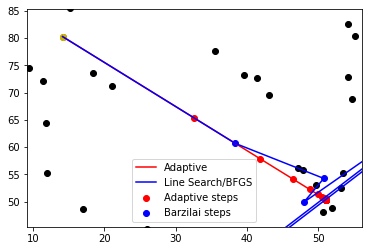

In [52]:
x0 = [X[i][0] for i in range(FIELDSIZE)]
x1 = [X[i][1] for i in range(FIELDSIZE)]
plt.xlim(min(TEST[0][0][0], TEST[0][-1][0])-5, max(TEST[0][0][0], TEST[0][-1][0])+5)
plt.ylim(min(TEST[0][0][1], TEST[0][-1][1])-5, max(TEST[0][0][1], TEST[0][-1][1])+5)
plt.scatter(x0,x1, c = 'k')
plt.plot(s_x_axis_adaptive, s_y_axis_adaptive, 'r', label = 'Adaptive')
plt.plot(s_x_axis_bfgs, s_y_axis_bfgs, 'b', label = 'Line Search/BFGS')
plt.scatter(s_x_axis_adaptive[1:], s_y_axis_adaptive[1:], c ='r', label = 'Adaptive steps')
plt.scatter(s_x_axis_bfgs[1:], s_y_axis_bfgs[1:], c ='b', label = 'Barzilai steps')
plt.scatter(S[0], S[1], c = 'y')
plt.legend(loc='best')
plt.savefig('crazy.png')
plt.show()

# BFGS Test

In [28]:
def f(x): return x[0]**2 + x[1]**2 +x[2]**2 -4*x[0] +x[1]*x[2]

In [29]:
def f_grad(x):
    l1 = 2*x[0] - 4
    l2 = 2*x[1] + x[2]
    l3 = 2*x[2] + x[1]
    return np.array([l1, l2 ,l3])

In [30]:
x_0 = np.array([1,1,1])

In [31]:
x_1 = np.array([17/7, 2/7, 2/7])

In [32]:
f_grad(x_0)

array([-2,  3,  3])

In [33]:
def BFGS(H0,x1,x0):
    s = x1 - x0
    g = f_grad(x1) - f_grad(x0)
    r = (H0@g.T)/np.dot(s,g)
    print('r', r)
    H1 = H0 + ((1 + np.dot(r,g))/np.dot(s,g))*s@s.T - ( s@r.T - r@s.T)
    print('H1', H1)
    d = - H1@f_grad(x1).T
    return d

In [34]:
H0 = np.array([[1,0,0],[0,1/3,0],[0,0,1/3]])

In [35]:
BFGS(H0, x_1, x_0)

r [ 0.4 -0.1 -0.1]
H1 [[2.10204082 1.10204082 1.10204082]
 [1.10204082 1.43537415 1.10204082]
 [1.10204082 1.10204082 1.43537415]]


array([-3.6909621 , -3.11953353, -3.11953353])

In [36]:
s = x_1 - x_0
s

array([ 1.42857143, -0.71428571, -0.71428571])

In [37]:
g = f_grad(x_1) - f_grad(x_0)

In [38]:
g

array([ 2.85714286, -2.14285714, -2.14285714])

In [39]:
-15/7

-2.142857142857143